# *Minecraft NLP Project*
### Presented by: Rae Downen, Cristina Lucin, Michael Mesa and John "Chris" Rosenberger

---

## Project Overview

This project focuses on building a prediction model for accurately predicting the coding language of a project using examination of GitHub repo README files. Our goal is to develop a predictive model utilizing Python and Python libraries, and select the most effective model for production. Initially, we are utilizing BeautifulSoup to acquire our data, selecting 1000 repositories tagged with 'Minecraft' from GitHub, taking in all Readme text and repo language information from each repo. After gathering the data, we explore the data through questions and visualizations before developing a model that can tell us: "What language is this repository most likely to be written in?"

## Goals
### Create deliverables:
* READ ME
* Final Report
* Functional acquire.py, explore.py, and model.py files
* Acquire data from GitHub utilizing Beautiful Soup to scrape targeted Repositories ('Repos')
* Prepare and split the data
* Explore the data
* Establish a baseline
* Fit and train a classification model to predict the programming language of the Repo
* Evaluate the model by comparing its performance on train utilizing accuracy as a measure
* Evaluate the selected model on test data
* Develop and document findings, takeaways, recommendations and next steps

In [1]:
#General DS Imports
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib as plt
from wordcloud import WordCloud, STOPWORDS
from matplotlib import pyplot as plt
from PIL import Image

#Modeling, NLP and Exploration
from requests import get
from bs4 import BeautifulSoup
import json
from typing import Dict, List, Optional, Union, cast
import requests
import re
import time
import unicodedata
import nltk
from sklearn.model_selection import train_test_split

#My imports
import os
from env import github_token, github_username
from importlib import reload
import acquire as a
import explore as e
import prepare as p

# Aquire
* 1,000 Repo URLs tagged "Minecraft" were aquired from GitHub utilizing a .py script "acquire_minecraft_urls.py"
* These Repos were identified and scraped through the search feature in GitHub
* Repo Readme Text and Repo Language was scraped utilizing BeautifulSoup
* Readme Text and Repo Language was collected into a dictionary using a function called "process_repo.py" and "scrape_github_data"
* This dictionary was turned into a dataframe and CSV file
* The CSV file contained 1,000 rows and 3 features before cleaning
* Each row represents a unique Repo located on Github
* Each column represents a feature of the Repo, such as URL, Readme text, or Programming Language

# Prepare
#### Prepare Actions:
* Renamed columns to improve readability
* Removed white space from values in object columns
* Checked for null values in the data, dropped all rows where nulls existed
* Utilized Regex and string methods and fucntions to clean Repo readme text

In [2]:
#Import our data from a .csv file, take a peek at the data
df = pd.read_csv(r'clean_scraped_data.csv', index_col=[0])
df.head()

,repo,language,readme_contents,clean,lemmatized
1,fogleman/Minecraft,Python,# Minecraft\n\nSimple Minecraft-inspired demo ...,minecraft simple minecraftinspired demo writte...,minecraft simple minecraftinspired demo writte...
2,itzg/docker-minecraft-server,Shell,[![Docker Pulls](https://img.shields.io/docker...,docker pullshttpsimgshieldsiodockerpullsitzgmi...,docker pullshttpsimgshieldsiodockerpullsitzgmi...
3,overviewer/Minecraft-Overviewer,Python,====================================\nMinecraf...,minecraft overviewer build status andrew brown...,minecraft overviewer build status andrew brown...
4,TheGreyGhost/MinecraftByExample,Java,MinecraftByExample [1.16.4]\n=================...,minecraftbyexample 1164 purpose minecraftbyexa...,minecraftbyexample 1164 purpose minecraftbyexa...
5,minecraft-dev/MinecraftDev,Kotlin,"<p align=""center""><a href=""https://minecraftde...",p aligncentera hrefhttpsminecraftdevorgimg src...,p aligncentera hrefhttpsminecraftdevorgimg src...


In [3]:
# top 20 languages from Readme files
df.language.value_counts().head(20)

Java          402
JavaScript     86
Python         76
C#             43
C++            36
Shell          35
PHP            33
Kotlin         23
TypeScript     22
Go             19
C              16
Rust           15
Lua             6
HTML            6
ZenScript       5
Ruby            5
CSS             4
GLSL            4
Dockerfile      4
Scala           4
Name: language, dtype: int64

### We chose to focus on the top 3 programming languages found in the scraped Repos, classifying all other languages as "Other":

In [4]:
#Recast other languages as "Other"
df = p.map_other_languages(df)
df.head()

,repo,language,readme_contents,clean,lemmatized
1,fogleman/Minecraft,Python,# Minecraft\n\nSimple Minecraft-inspired demo ...,minecraft simple minecraftinspired demo writte...,minecraft simple minecraftinspired demo writte...
2,itzg/docker-minecraft-server,Other,[![Docker Pulls](https://img.shields.io/docker...,docker pullshttpsimgshieldsiodockerpullsitzgmi...,docker pullshttpsimgshieldsiodockerpullsitzgmi...
3,overviewer/Minecraft-Overviewer,Python,====================================\nMinecraf...,minecraft overviewer build status andrew brown...,minecraft overviewer build status andrew brown...
4,TheGreyGhost/MinecraftByExample,Java,MinecraftByExample [1.16.4]\n=================...,minecraftbyexample 1164 purpose minecraftbyexa...,minecraftbyexample 1164 purpose minecraftbyexa...
5,minecraft-dev/MinecraftDev,Other,"<p align=""center""><a href=""https://minecraftde...",p aligncentera hrefhttpsminecraftdevorgimg src...,p aligncentera hrefhttpsminecraftdevorgimg src...


In [5]:
df.language.value_counts()

Java          402
Other         320
JavaScript     86
Python         76
Name: language, dtype: int64

### Train-Test Split

* For exploration, we chose to do a train test split taking 20% for test, %30 of that for validate, and the remainder for train

In [6]:
train, validate, test = e.split_minecraft_data(df)
train.head()

,repo,language,readme_contents,clean,lemmatized
47,danba340/minecraft-freecodecamp,JavaScript,# Welcome to React three fiber Minecraft\n\nTh...,welcome react three fiber minecraft project tr...,welcome react three fiber minecraft project tr...
822,BentoBoxWorld/AOneBlock,Java,"# AOneBlock\nA OneBlock Minecraft plugin, writ...",aoneblock oneblock minecraft plugin written ta...,aoneblock oneblock minecraft plugin written ta...
279,PGMDev/PGM,Java,PGM ![deploy](https://github.com/Electroid/PGM...,pgm deployhttpsgithubcomelectroidpgmworkflowsd...,pgm deployhttpsgithubcomelectroidpgmworkflowsd...
901,SandboxPowered/Sandbox,Java,"<p align=""center"">\n <img src=""https://raw....",p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...
266,mraof/Minestuck,Java,Minestuck\n=========\n\n* Discord Server: http...,minestuck discord server httpsdiscordappcominv...,minestuck discord server httpsdiscordappcominv...


## Question 1: What are the top programming languages found in #Minecraft GitHub Repos?

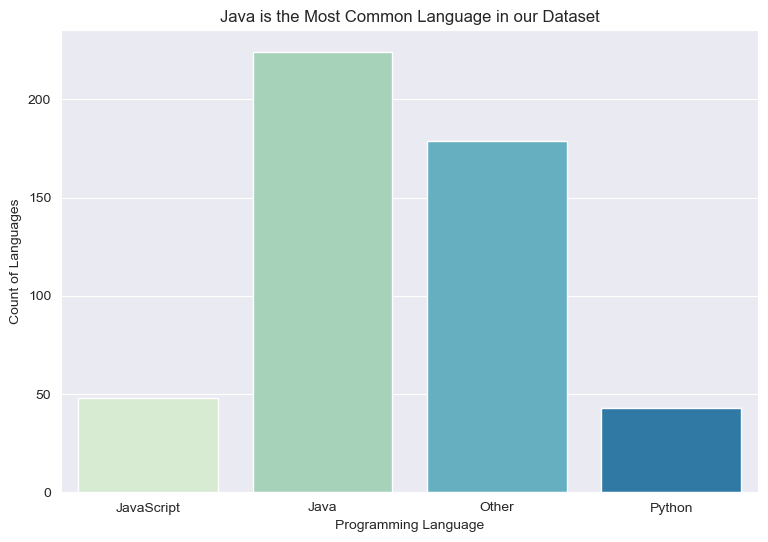

In [7]:
e.get_language_freq(train)